In [41]:
import pandas as pd
import re

# Define regex patterns
regex_patterns = {
    "timestamp": r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}\+\d{4}',
    "event_type": r'(Session|IncomingRequest|SuccessfulLogin|FailedLogin|AuthorisedAccess)',
    "user": r'(admin|user_dl|user_hp|phone1)',
    "ip": r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
}

# Define a function to parse each line of the text
def parse_line(line):
    # Use regular expressions to extract relevant information
    match = re.match(regex_patterns["timestamp"], line)
    if match:
        timestamp = match.group()
        match = re.search(regex_patterns["event_type"], line)
        event_type = match.group() if match else None
        match = re.search(regex_patterns["user"], line)
        user = match.group() if match else None
        match = re.search(regex_patterns["ip"], line)
        ip = match.group() if match else None

        return {
            'Timestamp': timestamp,
            'Event_Type': event_type,
            'User': user,
            'IP': ip
        }
    else:
        return None

# Read the text file and parse each line
with open('auth2.log', 'r') as file:
    lines = file.readlines()

# Filter out None values (lines that couldn't be parsed)
parsed_data = [parse_line(line) for line in lines]
parsed_data = [data for data in parsed_data if data is not None]

# Create DataFrame
df = pd.DataFrame(parsed_data)

# Display DataFrame


In [42]:
df['IP'] = df['IP'].replace('192.168.1.144', '192.168.70.173')

In [43]:
df

,Timestamp,Event_Type,User,IP
0,2024-05-08T15:08:06.221877+0400,Session,None,127.0.0.1
1,2024-05-08T15:08:06.222209+0400,IncomingRequest,None,127.0.0.1
2,2024-05-08T15:11:39.291316+0400,SuccessfulLogin,admin,127.0.0.1
3,2024-05-08T15:11:43.046072+0400,IncomingRequest,None,127.0.0.1
4,2024-05-08T15:11:43.046944+0400,AuthorisedAccess,admin,127.0.0.1
...,...,...,...,...
12646,2024-05-08T16:40:05.462619+0400,None,phone1,None
12647,2024-05-08T16:43:32.066490+0400,Session,None,192.168.1.250
12648,2024-05-08T16:43:32.066861+0400,IncomingRequest,None,192.168.1.250
12649,2024-05-08T16:43:48.566778+0400,SuccessfulLogin,phone1,192.168.1.250


In [45]:
df[df['Event_Type'] == 'Session'].shape[0]

6314

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score

df_transformed = pd.DataFrame()

# Feature Engineering
label_encoder = LabelEncoder()

# Encoding categorical features
df_transformed['Event_Type_Encoded'] = label_encoder.fit_transform(df['Event_Type'])
df_transformed['User_Encoded'] = label_encoder.fit_transform(df['User'].fillna('None'))  # Handle missing values
df_transformed['IP_Encoded'] = label_encoder.fit_transform(df['IP'].fillna('None'))  # Handle missing values

# Define features
features = ['Event_Type_Encoded', 'User_Encoded', 'IP_Encoded']
X = df_transformed[features]

# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test = train_test_split(X_scaled, test_size=0.35, random_state=42)

# Model Training
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# Model Evaluation
anomaly_scores_train = model.decision_function(X_train)
anomaly_scores_test = model.decision_function(X_test)

# Calculate average anomaly scores
avg_anomaly_score_train = anomaly_scores_train.mean()
avg_anomaly_score_test = anomaly_scores_test.mean()

print("Average Anomaly Score (Train):", avg_anomaly_score_train)
print("Average Anomaly Score (Test ):", avg_anomaly_score_test)

Average Anomaly Score (Train): 0.000717493626412889
Average Anomaly Score (Test ): 0.0008105213050989926


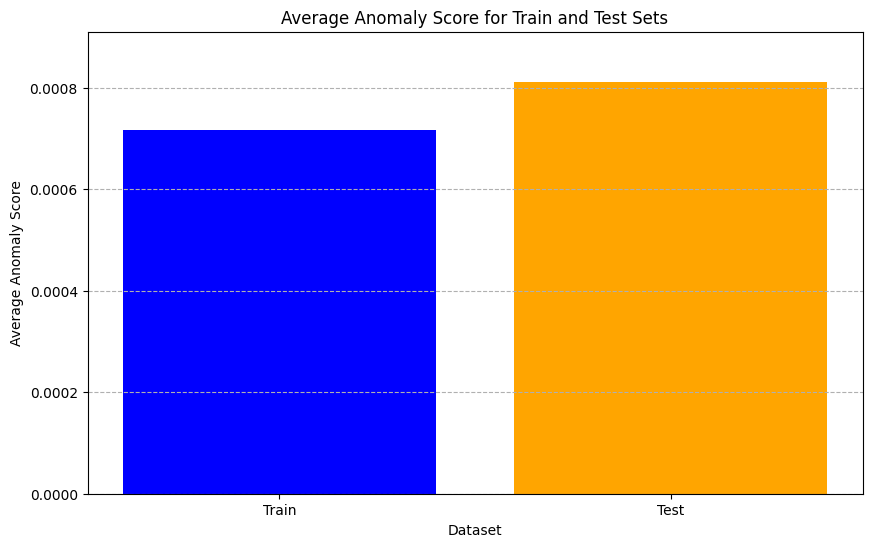

In [49]:
import matplotlib.pyplot as plt


# Data for plotting
categories = ['Train', 'Test']
scores = [avg_anomaly_score_train, avg_anomaly_score_test]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Average Anomaly Score')
plt.title('Average Anomaly Score for Train and Test Sets')

# Adjust y-axis limit and margins
plt.ylim(0, max(scores) + 0.0001)  # Adjust y-axis limit to better show the difference
plt.grid(axis='y', linestyle='--', alpha=1)  # Add a grid for better readability
plt.show()


In [24]:
from sklearn.metrics import roc_auc_score

# Create a binary ground truth label for anomalies (example)
# This should be based on your actual anomaly labels, not placeholders
# For demonstration purposes, we're assuming equal split, which might not be correct
# You need actual labels for real evaluation
y_true_train = [1] * (len(X_train) // 2) + [0] * (len(X_train) - len(X_train) // 2)
y_true_test = [1] * (len(X_test) // 2) + [0] * (len(X_test) - len(X_test) // 2)

# Ensure that your true labels match the lengths of the predicted scores
y_true_train = y_true_train[:len(anomaly_scores_train)]
y_true_test = y_true_test[:len(anomaly_scores_test)]

# Calculate ROC AUC Scores
roc_auc_train = roc_auc_score(y_true_train, -anomaly_scores_train)  # Negative for anomaly scores
roc_auc_test = roc_auc_score(y_true_test, -anomaly_scores_test)  # Negative for anomaly scores

print("ROC AUC Score (Train):", roc_auc_train)
print("ROC AUC Score (Test):", roc_auc_test)


ROC AUC Score (Train): 0.5009003070792699
ROC AUC Score (Test): 0.49237273220882505


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Example lists to store metrics
training_loss = []
validation_loss = []

# Your training loop
for epoch in range(num_epochs):
    # Train the model
    model.fit(X_train, y_train)

    # Calculate training loss or accuracy
    train_pred = model.predict(X_train)
    train_loss = 1 - accuracy_score(y_train, train_pred)  # Example metric
    training_loss.append(train_loss)

    # Calculate validation loss or accuracy
    val_pred = model.predict(X_test)
    val_loss = 1 - accuracy_score(y_test, val_pred)  # Example metric
    validation_loss.append(val_loss)

# Plotting
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


NameError: name 'num_epochs' is not defined

In [7]:
df_transformed['IP_Encoded'].unique()

array([0, 3, 2, 4, 5, 1])

In [8]:
# 1. Event Type Distribution
event_type_distribution = df['Event_Type'].value_counts()
print("Event Type Distribution:\n", event_type_distribution, "\n")

# 2. User Activity
user_activity = df.groupby('User').size()
print("User Activity:\n", user_activity, "\n")

# 3. IP Analysis
ip_analysis = df['IP'].value_counts()
print("IP Analysis:\n", ip_analysis, "\n")

# 4. Temporal Patterns
df['Hour'] = df['Timestamp'].dt.hour
hourly_activity = df.groupby('Hour').size()
print("Hourly Activity:\n", hourly_activity, "\n")

# 5. Event Correlation (Example: Successful Login followed by Authorised Access)
success_login_indices = df[df['Event_Type'] == 'SuccessfulLogin'].index
success_login_indices_plus_2 = success_login_indices + 2

# Filter out indices that go beyond the DataFrame's index range
valid_indices = success_login_indices_plus_2[success_login_indices_plus_2 < len(df)]

success_auth_access = df.loc[valid_indices][df.loc[valid_indices, 'Event_Type'] == 'AuthorisedAccess']
print("Successful Login followed by Authorised Access:\n", success_auth_access, "\n")



Event Type Distribution:
 Event_Type
Session             6319
IncomingRequest     6314
SuccessfulLogin       14
FailedLogin            2
AuthorisedAccess       1
Name: count, dtype: int64 

User Activity:
 User
admin      11
phone1      2
user_dl     3
user_hp     2
dtype: int64 

IP Analysis:
 IP
192.168.70.173    12612
127.0.0.1            17
192.168.1.253        10
192.168.1.53          7
192.168.1.250         4
Name: count, dtype: int64 



AttributeError: Can only use .dt accessor with datetimelike values